### Sentinel-3数据处理
#### 1. geophysical correction.
#### 2. waveform retracking.


In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from pyrsimg import readTiff, imgShow, second_to_dyr


In [19]:
def hz01_hz20(data_01hz, time_01hz, time_20hz):
    '''
    des: convert 01hz data to 20hz data through time nearest interpolation. 
    '''
    time_20hz_ = np.expand_dims(time_20hz, axis=1)
    dif_time = abs(time_20hz_ - time_01hz)
    ind_min = dif_time.argmin(axis=1)
    data_20hz = data_01hz[ind_min]
    return data_20hz


In [12]:
## s3 data
path_s3l2 = 'data/sentinel-3/S3A_SR_2_LAN____20200523T030933_20200523T035741_20200617T203903_2888_058_289______LN3_O_NT_004.SEN3/enhanced_measurement.nc'
## remote sensing data
path_rsimg = 'data/rsimg/dianchi_s2_20200511_wgs84.tif'
path_rsimg_wat = 'data/rsimg/dianchi_s2_20200511_wat_wgs84.tif'


In [13]:
## 1. s3l2 altimetry data
s3l2 = nc.Dataset(path_s3l2)   ##
## 2. remote sensing image
rsimg = readTiff(path_rsimg)


In [14]:
# print('variables: ', s3l2.variables.keys())
for i in range(len(s3l2.variables.keys())):
    print(list(s3l2.variables.keys())[i])


time_01
time_20_ku
time_20_c
echo_sample_ind
UTC_day_01
UTC_sec_01
UTC_day_20_ku
UTC_sec_20_ku
UTC_day_20_c
UTC_sec_20_c
UTC_time_1hz_20_ku
UTC_time_1hz_20_c
lat_01
lon_01
lat_20_ku
lon_20_ku
lat_20_c
lon_20_c
lat_cor_20_ku
lon_cor_20_ku
lat_cor_20_c
lon_cor_20_c
surf_type_01
surf_type_20_ku
surf_type_20_c
surf_class_01
surf_class_20_ku
surf_class_20_c
rad_surf_type_01
dist_coast_01
dist_coast_20_ku
dist_coast_20_c
alt_01
alt_20_ku
alt_20_c
orb_alt_rate_01
orb_alt_rate_20_ku
orb_alt_rate_20_c
tracker_range_20_ku
tracker_range_20_c
tracker_range_20_plrm_ku
h0_nav_dem_20_ku
agc_01_ku
agc_01_c
agc_01_plrm_ku
agc_20_ku
agc_20_c
agc_20_plrm_ku
agc_numval_01_ku
agc_numval_01_c
agc_numval_01_plrm_ku
agc_rms_01_ku
agc_rms_01_c
agc_rms_01_plrm_ku
agc_qual_20_ku
agc_qual_20_c
agc_qual_20_plrm_ku
scale_factor_20_ku
scale_factor_20_c
scale_factor_20_plrm_ku
range_ocean_01_ku
range_ocean_01_c
range_ocean_01_plrm_ku
range_ocean_20_ku
range_ocean_20_c
range_ocean_20_plrm_ku
range_ocean_qual_01_ku
ran

In [15]:
lat_20_ku = s3l2['lat_cor_20_ku'][:]
lon_20_ku = s3l2['lon_cor_20_ku'][:]
time_20_ku = s3l2['time_20_ku'][:]
time_20_ku = second_to_dyr(time_20_ku)


Text(0.5, 1.0, 'sentinel-3 altimetry data')

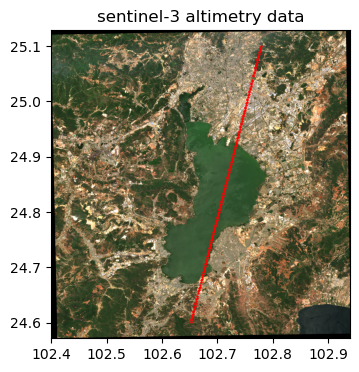

In [16]:
ids = np.where((lat_20_ku[:]>24.6) & (lat_20_ku[:]<25.1))  
fig = plt.figure(figsize=(4, 4))
plt.subplot(1,1,1)
imgShow(rsimg.array, extent=rsimg.geoextent)
plt.scatter(x=lon_20_ku[ids], y=lat_20_ku[ids], s=0.5, color='red')  ## altimetry data
plt.title('sentinel-3 altimetry data')



### <font color='yellow'>**1. Geophysical correction for the retracked range.**</font>

In [20]:
## 1. geophysical correction by refering to official document.
geo_corr_01hz=['mod_dry_tropo_cor_meas_altitude_01', 'mod_wet_tropo_cor_meas_altitude_01', 'iono_cor_gim_01_ku', 'load_tide_sol1_01', 'solid_earth_tide_01', 'pole_tide_01']
corr_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  corr_01hz += s3l2[cor_01hz_name][:]
print(corr_01hz.shape)


(1724,)


In [21]:
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = s3l2['time_20_ku'][:]
times_01 = s3l2['time_01'][:]
corr_20hz = hz01_hz20(data_01hz=corr_01hz, time_01hz=times_01, time_20hz=times_20)


In [22]:
## 3. Calculate the corrected surface water height
## 3.1 ocean retracker
h_cor_ocean = s3l2['alt_20_ku'][:] - s3l2['range_ocean_20_ku'][:] - corr_20hz
h_cor_ocean = h_cor_ocean.filled(np.nan)
## 3.2 ocog retracker
h_cor_ocog = s3l2['alt_20_ku'][:] - s3l2['range_ocog_20_ku'][:] - corr_20hz
h_cor_ocog = h_cor_ocog.filled(np.nan)


(1854.1, 1855.4)

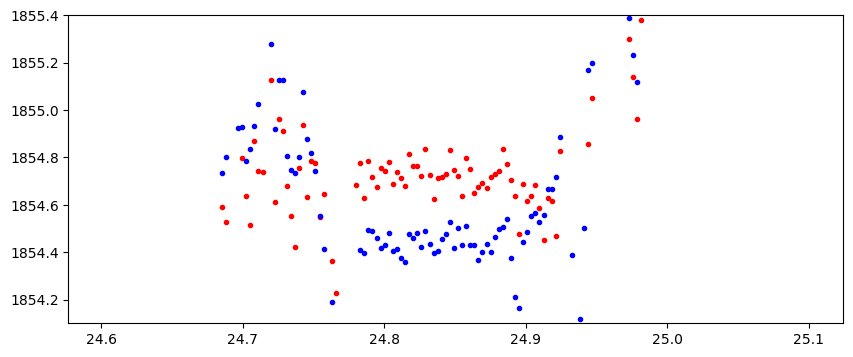

In [27]:
plt.figure(figsize=(10,4))
plt.plot(lat_20_ku[ids], h_cor_ocog[ids], 'r.')
plt.plot(lat_20_ku[ids], h_cor_ocean[ids], 'b.')
plt.ylim(1854.1, 1855.4)



### <font color='yellow'>**2. Atimeter range correction with manually waveform retracker.**</font>


(40.0, 90.0)

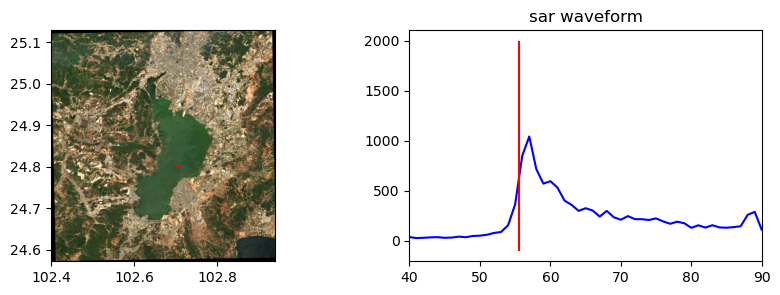

In [37]:
gate_retrack = 55.5
ids = np.argmin(abs((lat_20_ku[:] - 24.8))) 
wf_sar = s3l2['waveform_20_ku'][:][ids]
fig, ax = plt.subplots(1,2, figsize=(10,3))
imgShow(rsimg.array, extent=rsimg.geoextent, ax=ax[0])
ax[0].scatter(x=lon_20_ku[ids], y=lat_20_ku[ids], s=2.5, color='red')  ## altimetry data
ax[1].plot(wf_sar, color='blue')
ax[1].set_title('sar waveform')
ax[1].vlines(gate_retrack, ymin=-100, ymax=2000, color='red')
ax[1].set_xlim(40,90)


In [45]:
### 1. the provided elevation (geophysical correction + waveform retracker)
print('ocog elevation:\n',s3l2['elevation_ocog_20_ku'][ids])
### 2. the geophysical corrected elevation with the provided altimeter range.
h_cor_ocog = s3l2['alt_20_ku'][:] - s3l2['range_ocog_20_ku'][:] - corr_20hz
print('ocog elevation with manually geophysical correction:\n', h_cor_ocog[ids])
### 3. the elevation with the geophyiscal correction and the retraked altimeter range.
cor_retrack = (gate_retrack-43)*3.125*0.3/2
print('range correction by manually retracker:\n', cor_retrack)
h_cor_retracked = s3l2['alt_20_ku'][ids] \
                      - (s3l2['tracker_range_20_ku'][ids]+cor_retrack)\
                      - corr_20hz[ids]
print('elevation with manually geophysical correction and retracker:\n', h_cor_retracked)


ocog elevation:
 1854.7406
ocog elevation with manually geophysical correction:
 1854.741100000006
range correction by manually retracker:
 5.859375
elevation with manually geophysical correction and retracker:
 1855.238825000029
